In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Solving sequential decision problem...
Converged after 6 iterations
=== SOLUTION ===
Start state: (0, 1)
Terminal states: {(3, 2): 1, (3, 1): -1}
Obstacle: (1, 1)

State Values:
Row 2:   1.54    1.71    1.90    1.00  
Row 1:   1.39     X      1.71   -1.00  
Row 0:   1.25    1.39    1.54    1.39  

Optimal Policy:
Row 2:  right  right  right  TERM  
Row 1:     up    X       up  TERM  
Row 0:     up  right     up   left 

Optimal path from start:
Step 1: (0, 1) --up--> (0, 2)
Step 2: (0, 2) --right--> (1, 2)
Step 3: (1, 2) --right--> (2, 2)
Step 4: (2, 2) --right--> (3, 2)
Reached terminal state (3, 2) with reward 1


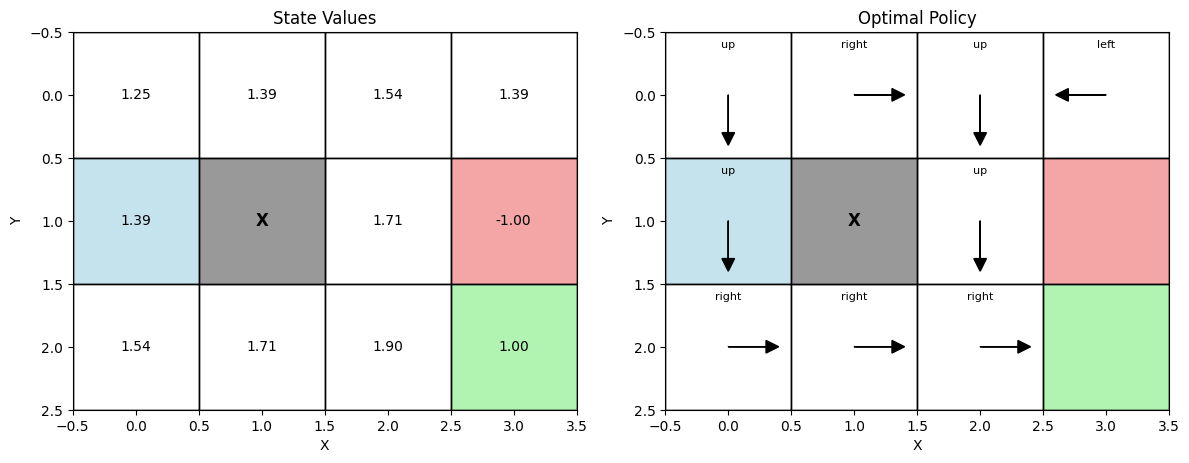

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class GridWorld:
    def __init__(self):
        self.grid_size = (4, 3)  # 4 columns, 3 rows
        self.start_state = (0, 1)  # (column, row) - bottom left is (0,0)
        self.terminal_states = {(3, 2): 1, (3, 1): -1}  # {state: reward}
        self.obstacle = (1, 1)  # blocked cell
        self.actions = ['up', 'down', 'left', 'right']
        self.action_effects = {
            'up': (0, 1),
            'down': (0, -1), 
            'left': (-1, 0),
            'right': (1, 0)
        }
        
    def is_valid_state(self, state):
        """Check if state is within bounds and not an obstacle"""
        x, y = state
        if x < 0 or x >= self.grid_size[0] or y < 0 or y >= self.grid_size[1]:
            return False
        if state == self.obstacle:
            return False
        return True
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        if state in self.terminal_states:
            return state  # Terminal states stay terminal
            
        x, y = state
        dx, dy = self.action_effects[action]
        next_state = (x + dx, y + dy)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        return next_state
    
    def get_all_states(self):
        """Get all valid states in the grid"""
        states = []
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if self.is_valid_state((x, y)):
                    states.append((x, y))
        return states

def value_iteration(grid_world, gamma=0.9, theta=1e-6, max_iterations=1000):
    """
    Solve the sequential decision problem using value iteration
    
    Args:
        grid_world: GridWorld instance
        gamma: discount factor
        theta: convergence threshold
        max_iterations: maximum number of iterations
    
    Returns:
        values: dictionary mapping states to their values
        policy: dictionary mapping states to optimal actions
    """
    states = grid_world.get_all_states()
    
    # Initialize values
    values = {state: 0.0 for state in states}
    
    # Set terminal state values
    for state, reward in grid_world.terminal_states.items():
        values[state] = reward
    
    for iteration in range(max_iterations):
        delta = 0
        new_values = values.copy()
        
        for state in states:
            if state in grid_world.terminal_states:
                continue  # Skip terminal states
                
            # Calculate value for each action
            action_values = []
            for action in grid_world.actions:
                next_state = grid_world.get_next_state(state, action)
                
                # Reward is 0 for non-terminal transitions
                # Only terminal states give +1 or -1 rewards
                if next_state in grid_world.terminal_states:
                    reward = grid_world.terminal_states[next_state]
                else:
                    reward = 0
                
                value = reward + gamma * values[next_state]
                action_values.append(value)
            
            # Update value with maximum action value
            new_values[state] = max(action_values)
            delta = max(delta, abs(new_values[state] - values[state]))
        
        values = new_values
        
        # Check for convergence
        if delta < theta:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    # Extract optimal policy
    policy = {}
    for state in states:
        if state in grid_world.terminal_states:
            policy[state] = None  # No action needed in terminal states
            continue
            
        best_action = None
        best_value = float('-inf')
        
        for action in grid_world.actions:
            next_state = grid_world.get_next_state(state, action)
            
            if next_state in grid_world.terminal_states:
                reward = grid_world.terminal_states[next_state]
            else:
                reward = 0
                
            value = reward + gamma * values[next_state]
            
            if value > best_value:
                best_value = value
                best_action = action
        
        policy[state] = best_action
    
    return values, policy

def visualize_solution(grid_world, values, policy):
    """Visualize the grid world with values and optimal policy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Values
    ax1.set_title('State Values')
    ax1.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
    ax1.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
    ax1.set_aspect('equal')
    
    # Draw grid
    for x in range(grid_world.grid_size[0] + 1):
        ax1.axvline(x - 0.5, color='black', linewidth=1)
    for y in range(grid_world.grid_size[1] + 1):
        ax1.axhline(y - 0.5, color='black', linewidth=1)
    
    # Fill cells with values
    for state in grid_world.get_all_states():
        x, y = state
        value = values[state]
        
        # Color based on value
        if state in grid_world.terminal_states:
            color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
        elif state == grid_world.start_state:
            color = 'lightblue'
        else:
            color = 'white'
            
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor=color, alpha=0.7)
        ax1.add_patch(rect)
        
        # Add value text
        ax1.text(x, y, f'{value:.2f}', ha='center', va='center', fontsize=10)
    
    # Mark obstacle
    if grid_world.obstacle:
        x, y = grid_world.obstacle
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor='gray', alpha=0.8)
        ax1.add_patch(rect)
        ax1.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.invert_yaxis()  # Invert y-axis to match typical grid representation
    
    # Plot 2: Policy
    ax2.set_title('Optimal Policy')
    ax2.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
    ax2.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
    ax2.set_aspect('equal')
    
    # Draw grid
    for x in range(grid_world.grid_size[0] + 1):
        ax2.axvline(x - 0.5, color='black', linewidth=1)
    for y in range(grid_world.grid_size[1] + 1):
        ax2.axhline(y - 0.5, color='black', linewidth=1)
    
    # Draw policy arrows
    arrow_map = {
        'up': (0, 0.3),
        'down': (0, -0.3),
        'left': (-0.3, 0),
        'right': (0.3, 0)
    }
    
    for state in grid_world.get_all_states():
        x, y = state
        
        # Color cells
        if state in grid_world.terminal_states:
            color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
        elif state == grid_world.start_state:
            color = 'lightblue'
        else:
            color = 'white'
            
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor=color, alpha=0.7)
        ax2.add_patch(rect)
        
        # Add policy arrow
        if policy[state] is not None:
            dx, dy = arrow_map[policy[state]]
            ax2.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, 
                     fc='black', ec='black')
            ax2.text(x, y-0.4, policy[state], ha='center', va='center', fontsize=8)
    
    # Mark obstacle
    if grid_world.obstacle:
        x, y = grid_world.obstacle
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor='gray', alpha=0.8)
        ax2.add_patch(rect)
        ax2.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def print_solution(grid_world, values, policy):
    """Print the solution in a readable format"""
    print("=== SOLUTION ===")
    print(f"Start state: {grid_world.start_state}")
    print(f"Terminal states: {grid_world.terminal_states}")
    print(f"Obstacle: {grid_world.obstacle}")
    print()
    
    print("State Values:")
    for y in range(grid_world.grid_size[1]-1, -1, -1):  # Print from top to bottom
        row_str = ""
        for x in range(grid_world.grid_size[0]):
            if (x, y) == grid_world.obstacle:
                row_str += "   X    "
            elif (x, y) in values:
                row_str += f"{values[(x,y)]:6.2f}  "
            else:
                row_str += "   -    "
        print(f"Row {y}: {row_str}")
    print()
    
    print("Optimal Policy:")
    for y in range(grid_world.grid_size[1]-1, -1, -1):  # Print from top to bottom
        row_str = ""
        for x in range(grid_world.grid_size[0]):
            if (x, y) == grid_world.obstacle:
                row_str += "   X   "
            elif (x, y) in policy:
                action = policy[(x, y)]
                if action is None:
                    row_str += " TERM  "
                else:
                    row_str += f"{action:>6} "
            else:
                row_str += "   -   "
        print(f"Row {y}: {row_str}")
    print()
    
    # Show optimal path from start
    print("Optimal path from start:")
    current_state = grid_world.start_state
    path = [current_state]
    steps = 0
    max_steps = 20  # Prevent infinite loops
    
    while current_state not in grid_world.terminal_states and steps < max_steps:
        action = policy[current_state]
        if action is None:
            break
        next_state = grid_world.get_next_state(current_state, action)
        path.append(next_state)
        print(f"Step {steps + 1}: {current_state} --{action}--> {next_state}")
        current_state = next_state
        steps += 1
    
    if current_state in grid_world.terminal_states:
        print(f"Reached terminal state {current_state} with reward {grid_world.terminal_states[current_state]}")
    
    return path

# Main execution
if __name__ == "__main__":
    # Create grid world
    grid = GridWorld()
    
    # Solve using value iteration
    print("Solving sequential decision problem...")
    values, policy = value_iteration(grid, gamma=0.9)
    
    # Print solution
    print_solution(grid, values, policy)
    
    # Visualize solution
    visualize_solution(grid, values, policy)

Solving Sequential Decision Problem with Different Horizons

1. INFINITE HORIZON CASE:
- No time restriction
- Stationary policy (optimal action doesn't change over time)
- Simpler policies
=== INFINITE HORIZON SOLUTION ===
Policy will be stationary (same optimal action at each state over time)
Converged after 6 iterations


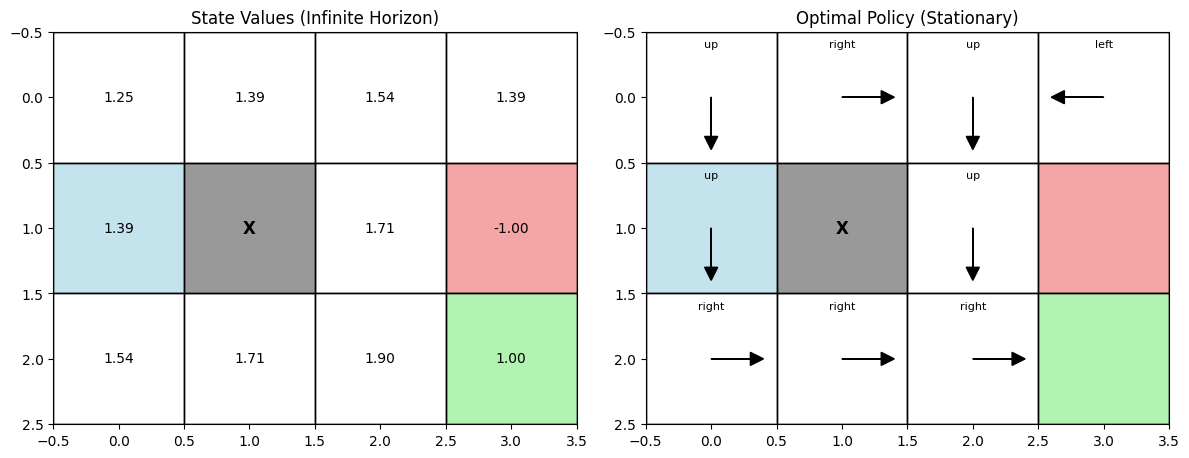


2. FINITE HORIZON CASE (N=10):
- After 10 steps, game over!
- Non-stationary policy (optimal action can change with remaining time)
- U(s1,s2,...,sN,...,sN+k) = U(s1,s2,...,st,...,sN)
=== FINITE HORIZON SOLUTION (N=10) ===
Policy will be non-stationary (optimal action may change with remaining time)


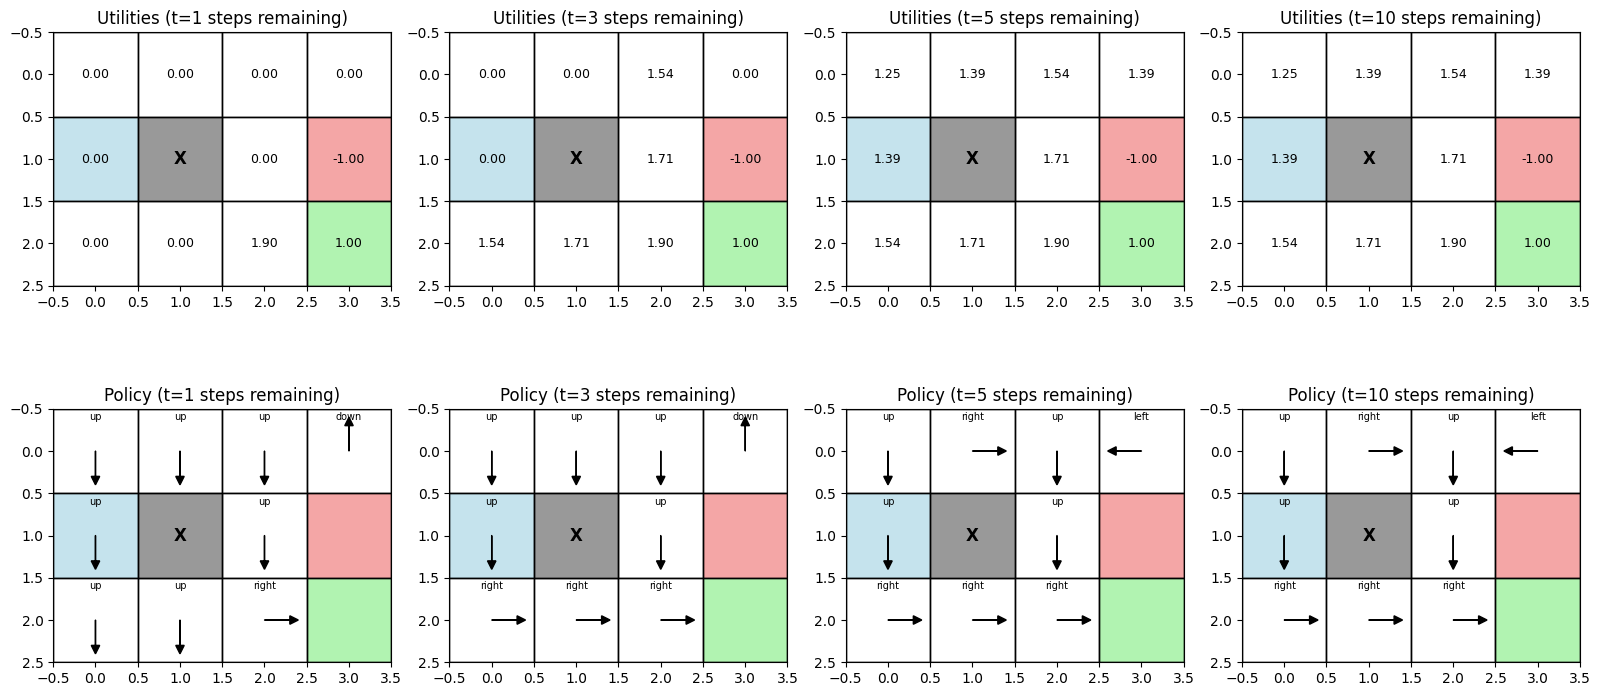


=== COMPARISON: FINITE vs INFINITE HORIZON ===

Infinite Horizon Policy (Stationary):
Row 2:  right  right  right  TERM  
Row 1:     up    X       up  TERM  
Row 0:     up  right     up   left 

Finite Horizon Policy at t=10 (Non-stationary):
Row 2:  right  right  right  TERM  
Row 1:     up    X       up  TERM  
Row 0:     up  right     up   left 

Policy Differences:
Policies are identical at this horizon!

=== HOW FINITE HORIZON POLICY CHANGES OVER TIME ===
As time runs out, the agent becomes more desperate/conservative:

With 10 steps remaining:
  At start state (0, 1): action=up, utility=1.385

With 5 steps remaining:
  At start state (0, 1): action=up, utility=1.385

With 2 steps remaining:
  At start state (0, 1): action=up, utility=0.000

With 1 steps remaining:
  At start state (0, 1): action=up, utility=0.000


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class GridWorld:
    def __init__(self):
        self.grid_size = (4, 3)  # 4 columns, 3 rows
        self.start_state = (0, 1)  # (column, row) - bottom left is (0,0)
        self.terminal_states = {(3, 2): 1, (3, 1): -1}  # {state: reward}
        self.obstacle = (1, 1)  # blocked cell
        self.actions = ['up', 'down', 'left', 'right']
        self.action_effects = {
            'up': (0, 1),
            'down': (0, -1), 
            'left': (-1, 0),
            'right': (1, 0)
        }
        
    def is_valid_state(self, state):
        """Check if state is within bounds and not an obstacle"""
        x, y = state
        if x < 0 or x >= self.grid_size[0] or y < 0 or y >= self.grid_size[1]:
            return False
        if state == self.obstacle:
            return False
        return True
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        if state in self.terminal_states:
            return state  # Terminal states stay terminal
            
        x, y = state
        dx, dy = self.action_effects[action]
        next_state = (x + dx, y + dy)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        return next_state
    
    def get_all_states(self):
        """Get all valid states in the grid"""
        states = []
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if self.is_valid_state((x, y)):
                    states.append((x, y))
        return states

def infinite_horizon_value_iteration(grid_world, gamma=0.9, theta=1e-6, max_iterations=1000):
    """
    Solve infinite horizon problem using value iteration
    - No time restriction
    - Stationary policy (optimal action at each state doesn't change over time)
    - Simpler policies
    """
    states = grid_world.get_all_states()
    
    # Initialize values
    values = {state: 0.0 for state in states}
    
    # Set terminal state values
    for state, reward in grid_world.terminal_states.items():
        values[state] = reward
    
    print("=== INFINITE HORIZON SOLUTION ===")
    print("Policy will be stationary (same optimal action at each state over time)")
    
    for iteration in range(max_iterations):
        delta = 0
        new_values = values.copy()
        
        for state in states:
            if state in grid_world.terminal_states:
                continue  # Skip terminal states
                
            # Calculate value for each action
            action_values = []
            for action in grid_world.actions:
                next_state = grid_world.get_next_state(state, action)
                
                # Reward is 0 for non-terminal transitions
                if next_state in grid_world.terminal_states:
                    reward = grid_world.terminal_states[next_state]
                else:
                    reward = 0
                
                value = reward + gamma * values[next_state]
                action_values.append(value)
            
            # Update value with maximum action value
            new_values[state] = max(action_values)
            delta = max(delta, abs(new_values[state] - values[state]))
        
        values = new_values
        
        if delta < theta:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    # Extract optimal policy (stationary)
    policy = {}
    for state in states:
        if state in grid_world.terminal_states:
            policy[state] = None
            continue
            
        best_action = None
        best_value = float('-inf')
        
        for action in grid_world.actions:
            next_state = grid_world.get_next_state(state, action)
            
            if next_state in grid_world.terminal_states:
                reward = grid_world.terminal_states[next_state]
            else:
                reward = 0
                
            value = reward + gamma * values[next_state]
            
            if value > best_value:
                best_value = value
                best_action = action
        
        policy[state] = best_action
    
    return values, policy

def finite_horizon_value_iteration(grid_world, horizon=10, gamma=0.9):
    """
    Solve finite horizon problem using backward induction
    - Fixed time limit N
    - Non-stationary policy (optimal action can change with time)
    - U(s1,s2,...,sN,...,sN+k) = U(s1,s2,...,st,...,sN) - utility after N steps doesn't matter
    """
    states = grid_world.get_all_states()
    
    print(f"=== FINITE HORIZON SOLUTION (N={horizon}) ===")
    print("Policy will be non-stationary (optimal action may change with remaining time)")
    
    # Initialize utility tables for each time step
    # utilities[t][state] = utility of being in state at time t
    utilities = {}
    policies = {}  # policies[t][state] = best action at state with t steps remaining
    
    # Base case: at time horizon (t=0 steps remaining), utility is 0 except for terminal states
    utilities[0] = {}
    policies[0] = {}
    
    for state in states:
        if state in grid_world.terminal_states:
            utilities[0][state] = grid_world.terminal_states[state]
            policies[0][state] = None  # No action needed at terminal states
        else:
            utilities[0][state] = 0.0  # Game over, no more reward possible
            policies[0][state] = None  # No action matters when time is up
    
    # Backward induction: work backwards from horizon
    for t in range(1, horizon + 1):  # t = steps remaining
        utilities[t] = {}
        policies[t] = {}
        
        for state in states:
            if state in grid_world.terminal_states:
                utilities[t][state] = grid_world.terminal_states[state]
                policies[t][state] = None
                continue
            
            # Find best action for this state with t steps remaining
            best_value = float('-inf')
            best_action = None
            
            for action in grid_world.actions:
                next_state = grid_world.get_next_state(state, action)
                
                # Immediate reward (0 for non-terminal transitions)
                if next_state in grid_world.terminal_states:
                    immediate_reward = grid_world.terminal_states[next_state]
                else:
                    immediate_reward = 0
                
                # Expected future utility (with t-1 steps remaining)
                future_utility = utilities[t-1][next_state]
                
                total_value = immediate_reward + gamma * future_utility
                
                if total_value > best_value:
                    best_value = total_value
                    best_action = action
            
            utilities[t][state] = best_value
            policies[t][state] = best_action
    
    # Return utilities and policies for all time steps
    return utilities, policies

def visualize_finite_horizon_solution(grid_world, utilities, policies, horizon):
    """Visualize finite horizon solution showing how policy changes over time"""
    # Show policies for a few different time steps
    time_steps_to_show = [1, 3, 5, horizon] if horizon >= 5 else list(range(1, horizon + 1))
    
    fig, axes = plt.subplots(2, len(time_steps_to_show), figsize=(4*len(time_steps_to_show), 8))
    if len(time_steps_to_show) == 1:
        axes = axes.reshape(2, 1)
    
    arrow_map = {
        'up': (0, 0.3), 'down': (0, -0.3),
        'left': (-0.3, 0), 'right': (0.3, 0)
    }
    
    for i, t in enumerate(time_steps_to_show):
        # Plot utilities
        ax1 = axes[0, i]
        ax1.set_title(f'Utilities (t={t} steps remaining)')
        ax1.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
        ax1.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
        ax1.set_aspect('equal')
        
        # Draw grid and values
        for x in range(grid_world.grid_size[0] + 1):
            ax1.axvline(x - 0.5, color='black', linewidth=1)
        for y in range(grid_world.grid_size[1] + 1):
            ax1.axhline(y - 0.5, color='black', linewidth=1)
        
        for state in grid_world.get_all_states():
            x, y = state
            value = utilities[t][state]
            
            if state in grid_world.terminal_states:
                color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
            elif state == grid_world.start_state:
                color = 'lightblue'
            else:
                color = 'white'
                
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                   linewidth=1, edgecolor='black', 
                                   facecolor=color, alpha=0.7)
            ax1.add_patch(rect)
            ax1.text(x, y, f'{value:.2f}', ha='center', va='center', fontsize=9)
        
        # Mark obstacle
        if grid_world.obstacle:
            x, y = grid_world.obstacle
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                   linewidth=1, edgecolor='black', 
                                   facecolor='gray', alpha=0.8)
            ax1.add_patch(rect)
            ax1.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
        
        ax1.invert_yaxis()
        
        # Plot policies
        ax2 = axes[1, i]
        ax2.set_title(f'Policy (t={t} steps remaining)')
        ax2.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
        ax2.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
        ax2.set_aspect('equal')
        
        # Draw grid
        for x in range(grid_world.grid_size[0] + 1):
            ax2.axvline(x - 0.5, color='black', linewidth=1)
        for y in range(grid_world.grid_size[1] + 1):
            ax2.axhline(y - 0.5, color='black', linewidth=1)
        
        for state in grid_world.get_all_states():
            x, y = state
            
            if state in grid_world.terminal_states:
                color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
            elif state == grid_world.start_state:
                color = 'lightblue'
            else:
                color = 'white'
                
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                   linewidth=1, edgecolor='black', 
                                   facecolor=color, alpha=0.7)
            ax2.add_patch(rect)
            
            # Add policy arrow
            if policies[t][state] is not None:
                dx, dy = arrow_map[policies[t][state]]
                ax2.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, 
                         fc='black', ec='black')
                ax2.text(x, y-0.4, policies[t][state], ha='center', va='center', fontsize=7)
        
        # Mark obstacle
        if grid_world.obstacle:
            x, y = grid_world.obstacle
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                   linewidth=1, edgecolor='black', 
                                   facecolor='gray', alpha=0.8)
            ax2.add_patch(rect)
            ax2.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
        
        ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def visualize_infinite_horizon_solution(grid_world, values, policy):
    """Visualize infinite horizon solution (single stationary policy)"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Values
    ax1.set_title('State Values (Infinite Horizon)')
    ax1.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
    ax1.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
    ax1.set_aspect('equal')
    
    # Draw grid
    for x in range(grid_world.grid_size[0] + 1):
        ax1.axvline(x - 0.5, color='black', linewidth=1)
    for y in range(grid_world.grid_size[1] + 1):
        ax1.axhline(y - 0.5, color='black', linewidth=1)
    
    # Fill cells with values
    for state in grid_world.get_all_states():
        x, y = state
        value = values[state]
        
        if state in grid_world.terminal_states:
            color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
        elif state == grid_world.start_state:
            color = 'lightblue'
        else:
            color = 'white'
            
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor=color, alpha=0.7)
        ax1.add_patch(rect)
        ax1.text(x, y, f'{value:.2f}', ha='center', va='center', fontsize=10)
    
    # Mark obstacle
    if grid_world.obstacle:
        x, y = grid_world.obstacle
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor='gray', alpha=0.8)
        ax1.add_patch(rect)
        ax1.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax1.invert_yaxis()
    
    # Plot 2: Policy
    ax2.set_title('Optimal Policy (Stationary)')
    ax2.set_xlim(-0.5, grid_world.grid_size[0] - 0.5)
    ax2.set_ylim(-0.5, grid_world.grid_size[1] - 0.5)
    ax2.set_aspect('equal')
    
    # Draw grid
    for x in range(grid_world.grid_size[0] + 1):
        ax2.axvline(x - 0.5, color='black', linewidth=1)
    for y in range(grid_world.grid_size[1] + 1):
        ax2.axhline(y - 0.5, color='black', linewidth=1)
    
    # Draw policy arrows
    arrow_map = {
        'up': (0, 0.3), 'down': (0, -0.3),
        'left': (-0.3, 0), 'right': (0.3, 0)
    }
    
    for state in grid_world.get_all_states():
        x, y = state
        
        if state in grid_world.terminal_states:
            color = 'lightgreen' if grid_world.terminal_states[state] > 0 else 'lightcoral'
        elif state == grid_world.start_state:
            color = 'lightblue'
        else:
            color = 'white'
            
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor=color, alpha=0.7)
        ax2.add_patch(rect)
        
        # Add policy arrow
        if policy[state] is not None:
            dx, dy = arrow_map[policy[state]]
            ax2.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, 
                     fc='black', ec='black')
            ax2.text(x, y-0.4, policy[state], ha='center', va='center', fontsize=8)
    
    # Mark obstacle
    if grid_world.obstacle:
        x, y = grid_world.obstacle
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor='gray', alpha=0.8)
        ax2.add_patch(rect)
        ax2.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def compare_horizons(grid_world, finite_utilities, finite_policies, infinite_values, infinite_policy, horizon):
    """Compare how policies change between finite and infinite horizon"""
    print("\n=== COMPARISON: FINITE vs INFINITE HORIZON ===")
    
    print(f"\nInfinite Horizon Policy (Stationary):")
    for y in range(grid_world.grid_size[1]-1, -1, -1):
        row_str = ""
        for x in range(grid_world.grid_size[0]):
            if (x, y) == grid_world.obstacle:
                row_str += "   X   "
            elif (x, y) in infinite_policy:
                action = infinite_policy[(x, y)]
                if action is None:
                    row_str += " TERM  "
                else:
                    row_str += f"{action:>6} "
            else:
                row_str += "   -   "
        print(f"Row {y}: {row_str}")
    
    print(f"\nFinite Horizon Policy at t={horizon} (Non-stationary):")
    for y in range(grid_world.grid_size[1]-1, -1, -1):
        row_str = ""
        for x in range(grid_world.grid_size[0]):
            if (x, y) == grid_world.obstacle:
                row_str += "   X   "
            elif (x, y) in finite_policies[horizon]:
                action = finite_policies[horizon][(x, y)]
                if action is None:
                    row_str += " TERM  "
                else:
                    row_str += f"{action:>6} "
            else:
                row_str += "   -   "
        print(f"Row {y}: {row_str}")
    
    # Check for differences
    print(f"\nPolicy Differences:")
    differences = []
    for state in grid_world.get_all_states():
        if state not in grid_world.terminal_states:
            infinite_action = infinite_policy[state]
            finite_action = finite_policies[horizon][state]
            if infinite_action != finite_action:
                differences.append((state, infinite_action, finite_action))
    
    if differences:
        print("States where policies differ:")
        for state, inf_action, fin_action in differences:
            print(f"  State {state}: Infinite={inf_action}, Finite={fin_action}")
    else:
        print("Policies are identical at this horizon!")

# Main execution
if __name__ == "__main__":
    # Create grid world
    grid = GridWorld()
    
    print("Solving Sequential Decision Problem with Different Horizons")
    print("=" * 60)
    
    # Solve infinite horizon case
    print("\n1. INFINITE HORIZON CASE:")
    print("- No time restriction")
    print("- Stationary policy (optimal action doesn't change over time)")
    print("- Simpler policies")
    
    infinite_values, infinite_policy = infinite_horizon_value_iteration(grid, gamma=0.9)
    visualize_infinite_horizon_solution(grid, infinite_values, infinite_policy)
    
    # Solve finite horizon case
    horizon = 10
    print(f"\n2. FINITE HORIZON CASE (N={horizon}):")
    print(f"- After {horizon} steps, game over!")
    print("- Non-stationary policy (optimal action can change with remaining time)")
    print("- U(s1,s2,...,sN,...,sN+k) = U(s1,s2,...,st,...,sN)")
    
    finite_utilities, finite_policies = finite_horizon_value_iteration(grid, horizon=horizon, gamma=0.9)
    visualize_finite_horizon_solution(grid, finite_utilities, finite_policies, horizon)
    
    # Compare the two approaches
    compare_horizons(grid, finite_utilities, finite_policies, infinite_values, infinite_policy, horizon)
    
    # Show how finite horizon policy changes with remaining time
    print(f"\n=== HOW FINITE HORIZON POLICY CHANGES OVER TIME ===")
    print("As time runs out, the agent becomes more desperate/conservative:")
    
    for t in [horizon, horizon//2, 2, 1]:
        if t in finite_policies:
            print(f"\nWith {t} steps remaining:")
            start_state = grid.start_state
            if start_state in finite_policies[t]:
                action = finite_policies[t][start_state]
                utility = finite_utilities[t][start_state]
                print(f"  At start state {start_state}: action={action}, utility={utility:.3f}")

POMDP Grid World - Agent doesn't know its exact location
Agent only observes the number of adjacent walls
=== SENSOR MODEL ANALYSIS ===
P(observation|state) - Probability of observing wall count given true state

States and their true adjacent wall counts:
  State (0, 0): 2 walls
  State (0, 1): 2 walls (Start)
  State (0, 2): 2 walls
  State (1, 0): 2 walls
  State (1, 2): 2 walls
  State (2, 0): 1 walls
  State (2, 1): 1 walls
  State (2, 2): 1 walls
  State (3, 0): 2 walls
  State (3, 1): 1 walls (Terminal: -1)
  State (3, 2): 2 walls (Terminal: +1)

Observation ambiguity:
  4 state(s) have 1 adjacent walls: [(2, 0), (2, 1), (2, 2), (3, 1)]
    -> Observation 1 is ambiguous!
  7 state(s) have 2 adjacent walls: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (3, 0), (3, 2)]
    -> Observation 2 is ambiguous!
=== SOLVING POMDP USING QMDP APPROXIMATION ===

=== INITIAL BELIEF STATE ===
Agent starts with uniform belief over all possible states


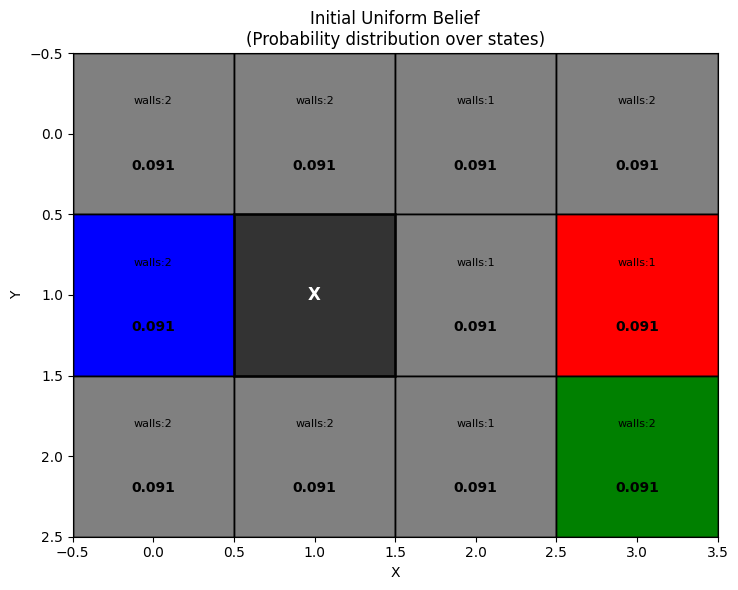


Agent observes 2 adjacent walls at start
Updating belief based on this observation...


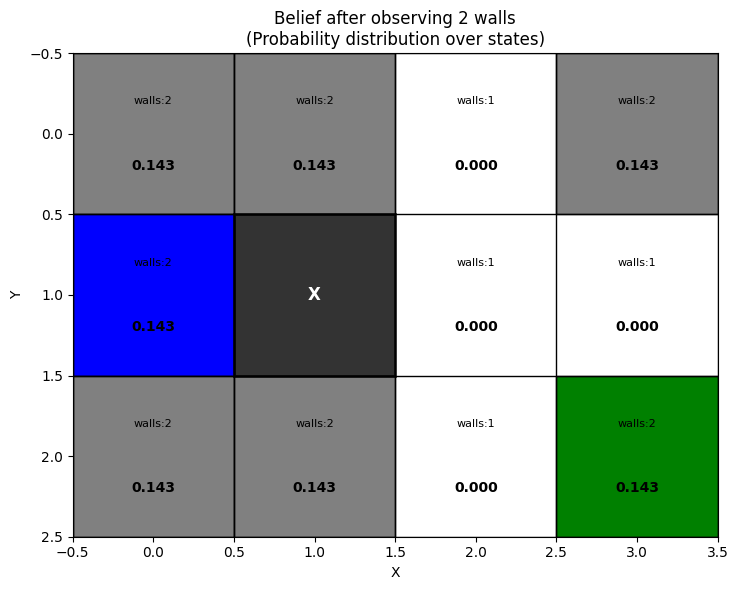


=== SIMULATING POMDP EPISODE ===
Starting at state: (0, 1)
Agent doesn't know its location, only observes adjacent wall count
Initial observation (adjacent walls): 2

--- Step 1 ---
Most likely state: (0, 0) (prob: 0.091)
Actual state: (0, 1)
Action values: {'up': 0.8964890909090909, 'down': 1.0756210909090909, 'left': 1.0882129090909092, 'right': 0.8745872727272728}
Chosen action: left
New state: (0, 1)
Observation (adjacent walls): 2
Reward: 0.0

--- Step 2 ---
Most likely state: (0, 0) (prob: 0.250)
Actual state: (0, 1)
Action values: {'up': 1.41675875, 'down': 1.3180703750000002, 'left': 1.333460375, 'right': 1.4766087499999998}
Chosen action: right
New state: (0, 1)
Observation (adjacent walls): 2
Reward: 0.0

--- Step 3 ---
Most likely state: (1, 0) (prob: 0.333)
Actual state: (0, 1)
Action values: {'up': 1.4760466666666665, 'down': 1.4321851666666665, 'left': 1.3601086666666666, 'right': 1.5561316666666667}
Chosen action: right
New state: (0, 1)
Observation (adjacent walls): 2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import itertools

class GridWorldPOMDP:
    def __init__(self):
        self.grid_size = (4, 3)  # 4 columns, 3 rows
        self.start_state = (0, 1)  # (column, row) - bottom left is (0,0)
        self.terminal_states = {(3, 2): 1, (3, 1): -1}  # {state: reward}
        self.obstacle = (1, 1)  # blocked cell
        self.actions = ['up', 'down', 'left', 'right']
        self.action_effects = {
            'up': (0, 1),
            'down': (0, -1), 
            'left': (-1, 0),
            'right': (1, 0)
        }
        
        # POMDP-specific components
        self.states = self.get_all_states()
        self.observations = self.get_all_observations()
        self.sensor_model = self.build_sensor_model()
        
    def is_valid_state(self, state):
        """Check if state is within bounds and not an obstacle"""
        x, y = state
        if x < 0 or x >= self.grid_size[0] or y < 0 or y >= self.grid_size[1]:
            return False
        if state == self.obstacle:
            return False
        return True
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        if state in self.terminal_states:
            return state  # Terminal states stay terminal
            
        x, y = state
        dx, dy = self.action_effects[action]
        next_state = (x + dx, y + dy)
        
        # If next state is invalid, stay in current state
        if not self.is_valid_state(next_state):
            return state
        return next_state
    
    def get_all_states(self):
        """Get all valid states in the grid"""
        states = []
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if self.is_valid_state((x, y)):
                    states.append((x, y))
        return states
    
    def count_adjacent_walls(self, state):
        """Count how many adjacent cells are walls or out of bounds"""
        x, y = state
        wall_count = 0
        
        # Check all four directions
        for dx, dy in [(0, 1), (0, -1), (-1, 0), (1, 0)]:
            adj_x, adj_y = x + dx, y + dy
            
            # Count as wall if out of bounds or obstacle
            if (adj_x < 0 or adj_x >= self.grid_size[0] or 
                adj_y < 0 or adj_y >= self.grid_size[1] or
                (adj_x, adj_y) == self.obstacle):
                wall_count += 1
                
        return wall_count
    
    def get_all_observations(self):
        """Get all possible observations (number of adjacent walls)"""
        observations = set()
        for state in self.states:
            obs = self.count_adjacent_walls(state)
            observations.add(obs)
        return sorted(list(observations))
    
    def build_sensor_model(self):
        """Build sensor model P(e|s) - probability of observing evidence e in state s"""
        sensor_model = {}
        
        for state in self.states:
            sensor_model[state] = {}
            true_wall_count = self.count_adjacent_walls(state)
            
            # Perfect sensor for now - always observes correct number of walls
            for obs in self.observations:
                if obs == true_wall_count:
                    sensor_model[state][obs] = 1.0
                else:
                    sensor_model[state][obs] = 0.0
                    
        return sensor_model
    
    def get_reward(self, state):
        """Get reward for being in a state"""
        if state in self.terminal_states:
            return self.terminal_states[state]
        return 0.0

class POMDPBelief:
    """Represents a belief state (probability distribution over states)"""
    def __init__(self, pomdp):
        self.pomdp = pomdp
        self.belief = {state: 1.0 / len(pomdp.states) for state in pomdp.states}  # Uniform initial belief
    
    def normalize(self):
        """Normalize belief to sum to 1"""
        total = sum(self.belief.values())
        if total > 0:
            for state in self.belief:
                self.belief[state] /= total
    
    def update_belief(self, action, observation):
        """Update belief after taking action and receiving observation"""
        new_belief = {}
        
        for next_state in self.pomdp.states:
            # Sum over all possible previous states
            prob_sum = 0.0
            for prev_state in self.pomdp.states:
                # Probability of transitioning from prev_state to next_state with action
                if self.pomdp.get_next_state(prev_state, action) == next_state:
                    transition_prob = 1.0  # Deterministic transitions
                else:
                    transition_prob = 0.0
                
                # Probability of observing evidence in next_state
                observation_prob = self.pomdp.sensor_model[next_state][observation]
                
                prob_sum += self.belief[prev_state] * transition_prob * observation_prob
            
            new_belief[next_state] = prob_sum
        
        self.belief = new_belief
        self.normalize()
    
    def get_expected_reward(self):
        """Get expected reward for current belief state"""
        expected_reward = 0.0
        for state in self.pomdp.states:
            expected_reward += self.belief[state] * self.pomdp.get_reward(state)
        return expected_reward
    
    def get_most_likely_state(self):
        """Get the most likely state according to current belief"""
        return max(self.belief.items(), key=lambda x: x[1])
    
    def copy(self):
        """Create a copy of this belief state"""
        new_belief = POMDPBelief(self.pomdp)
        new_belief.belief = self.belief.copy()
        return new_belief

def solve_pomdp_qmdp(pomdp, gamma=0.9, theta=1e-6, max_iterations=1000):
    """
    Solve POMDP using QMDP approximation
    QMDP assumes that after the current action, the agent will have perfect information
    """
    print("=== SOLVING POMDP USING QMDP APPROXIMATION ===")
    
    # First, solve the underlying MDP (assuming full observability)
    values = {state: 0.0 for state in pomdp.states}
    
    # Set terminal state values
    for state, reward in pomdp.terminal_states.items():
        values[state] = reward
    
    # Value iteration for underlying MDP
    for iteration in range(max_iterations):
        delta = 0
        new_values = values.copy()
        
        for state in pomdp.states:
            if state in pomdp.terminal_states:
                continue
                
            action_values = []
            for action in pomdp.actions:
                next_state = pomdp.get_next_state(state, action)
                reward = pomdp.get_reward(next_state)
                value = reward + gamma * values[next_state]
                action_values.append(value)
            
            new_values[state] = max(action_values)
            delta = max(delta, abs(new_values[state] - values[state]))
        
        values = new_values
        if delta < theta:
            break
    
    # Compute Q-values for each state-action pair
    q_values = {}
    for state in pomdp.states:
        q_values[state] = {}
        for action in pomdp.actions:
            next_state = pomdp.get_next_state(state, action)
            reward = pomdp.get_reward(next_state)
            q_values[state][action] = reward + gamma * values[next_state]
    
    return values, q_values

def qmdp_policy(belief, q_values):
    """
    QMDP policy: choose action that maximizes expected Q-value under current belief
    """
    action_values = {}
    
    for action in belief.pomdp.actions:
        expected_q = 0.0
        for state in belief.pomdp.states:
            expected_q += belief.belief[state] * q_values[state][action]
        action_values[action] = expected_q
    
    best_action = max(action_values.items(), key=lambda x: x[1])
    return best_action[0], action_values

def simulate_pomdp_episode(pomdp, q_values, start_state=None, max_steps=20):
    """
    Simulate an episode of the POMDP
    """
    if start_state is None:
        start_state = pomdp.start_state
    
    print(f"\n=== SIMULATING POMDP EPISODE ===")
    print(f"Starting at state: {start_state}")
    print(f"Agent doesn't know its location, only observes adjacent wall count")
    
    # Initialize belief state
    belief = POMDPBelief(pomdp)
    current_state = start_state
    
    # Get initial observation
    initial_obs = pomdp.count_adjacent_walls(current_state)
    print(f"Initial observation (adjacent walls): {initial_obs}")
    
    episode_history = []
    total_reward = 0
    
    for step in range(max_steps):
        print(f"\n--- Step {step + 1} ---")
        
        # Show current belief
        most_likely_state, prob = belief.get_most_likely_state()
        print(f"Most likely state: {most_likely_state} (prob: {prob:.3f})")
        print(f"Actual state: {current_state}")
        
        # Check if in terminal state
        if current_state in pomdp.terminal_states:
            reward = pomdp.terminal_states[current_state]
            total_reward += reward
            print(f"Reached terminal state! Reward: {reward}")
            break
        
        # Choose action using QMDP policy
        action, action_values = qmdp_policy(belief, q_values)
        print(f"Action values: {action_values}")
        print(f"Chosen action: {action}")
        
        # Execute action
        next_state = pomdp.get_next_state(current_state, action)
        reward = pomdp.get_reward(next_state)
        total_reward += reward
        
        # Get observation
        observation = pomdp.count_adjacent_walls(next_state)
        print(f"New state: {next_state}")
        print(f"Observation (adjacent walls): {observation}")
        print(f"Reward: {reward}")
        
        # Update belief
        belief.update_belief(action, observation)
        
        episode_history.append({
            'step': step + 1,
            'state': current_state,
            'action': action,
            'next_state': next_state,
            'observation': observation,
            'reward': reward,
            'belief_before': belief.belief.copy()
        })
        
        current_state = next_state
    
    print(f"\nEpisode finished. Total reward: {total_reward}")
    return episode_history, total_reward

def visualize_pomdp_belief(pomdp, belief, title="Belief State"):
    """Visualize the current belief state"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    ax.set_title(f'{title}\n(Probability distribution over states)')
    ax.set_xlim(-0.5, pomdp.grid_size[0] - 0.5)
    ax.set_ylim(-0.5, pomdp.grid_size[1] - 0.5)
    ax.set_aspect('equal')
    
    # Draw grid
    for x in range(pomdp.grid_size[0] + 1):
        ax.axvline(x - 0.5, color='black', linewidth=1)
    for y in range(pomdp.grid_size[1] + 1):
        ax.axhline(y - 0.5, color='black', linewidth=1)
    
    # Color cells based on belief probability
    max_prob = max(belief.belief.values())
    
    for state in pomdp.states:
        x, y = state
        prob = belief.belief[state]
        
        # Color intensity based on probability
        alpha = prob / max_prob if max_prob > 0 else 0
        
        if state in pomdp.terminal_states:
            base_color = 'green' if pomdp.terminal_states[state] > 0 else 'red'
        elif state == pomdp.start_state:
            base_color = 'blue'
        else:
            base_color = 'gray'
            
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=1, edgecolor='black', 
                               facecolor=base_color, alpha=alpha)
        ax.add_patch(rect)
        
        # Add probability text
        ax.text(x, y+0.2, f'{prob:.3f}', ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Add wall count observation
        wall_count = pomdp.count_adjacent_walls(state)
        ax.text(x, y-0.2, f'walls:{wall_count}', ha='center', va='center', fontsize=8)
    
    # Mark obstacle
    if pomdp.obstacle:
        x, y = pomdp.obstacle
        rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                               linewidth=2, edgecolor='black', 
                               facecolor='black', alpha=0.8)
        ax.add_patch(rect)
        ax.text(x, y, 'X', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def analyze_sensor_model(pomdp):
    """Analyze and display the sensor model"""
    print("=== SENSOR MODEL ANALYSIS ===")
    print("P(observation|state) - Probability of observing wall count given true state")
    
    print(f"\nStates and their true adjacent wall counts:")
    for state in pomdp.states:
        wall_count = pomdp.count_adjacent_walls(state)
        state_type = ""
        if state in pomdp.terminal_states:
            state_type = f" (Terminal: {pomdp.terminal_states[state]:+d})"
        elif state == pomdp.start_state:
            state_type = " (Start)"
        print(f"  State {state}: {wall_count} walls{state_type}")
    
    # Group states by observation
    obs_to_states = defaultdict(list)
    for state in pomdp.states:
        obs = pomdp.count_adjacent_walls(state)
        obs_to_states[obs].append(state)
    
    print(f"\nObservation ambiguity:")
    for obs in sorted(obs_to_states.keys()):
        states = obs_to_states[obs]
        print(f"  {len(states)} state(s) have {obs} adjacent walls: {states}")
        if len(states) > 1:
            print(f"    -> Observation {obs} is ambiguous!")

# Main execution
if __name__ == "__main__":
    print("POMDP Grid World - Agent doesn't know its exact location")
    print("Agent only observes the number of adjacent walls")
    print("=" * 60)
    
    # Create POMDP
    pomdp = GridWorldPOMDP()
    
    # Analyze the sensor model
    analyze_sensor_model(pomdp)
    
    # Solve using QMDP approximation
    values, q_values = solve_pomdp_qmdp(pomdp, gamma=0.9)
    
    # Create initial belief (uniform over all states)
    initial_belief = POMDPBelief(pomdp)
    
    print(f"\n=== INITIAL BELIEF STATE ===")
    print("Agent starts with uniform belief over all possible states")
    visualize_pomdp_belief(pomdp, initial_belief, "Initial Uniform Belief")
    
    # Simulate getting first observation and updating belief
    true_start_state = pomdp.start_state
    first_observation = pomdp.count_adjacent_walls(true_start_state)
    
    print(f"\nAgent observes {first_observation} adjacent walls at start")
    print("Updating belief based on this observation...")
    
    # Update belief based on first observation (no action taken yet)
    updated_belief = POMDPBelief(pomdp)
    # Manually update belief based on sensor model
    for state in pomdp.states:
        if pomdp.sensor_model[state][first_observation] > 0:
            updated_belief.belief[state] = 1.0
        else:
            updated_belief.belief[state] = 0.0
    updated_belief.normalize()
    
    visualize_pomdp_belief(pomdp, updated_belief, f"Belief after observing {first_observation} walls")
    
    # Run simulation
    episode_history, total_reward = simulate_pomdp_episode(pomdp, q_values, true_start_state)
    
    print(f"\n=== POMDP COMPONENTS SUMMARY ===")
    print(f"States S: {pomdp.states}")
    print(f"Actions A(s): {pomdp.actions} (same for all states)")
    print(f"Observations: {pomdp.observations} (number of adjacent walls)")
    print(f"Sensor model P(e|s): Agent observes true wall count with probability 1.0")
    print(f"Transition model P(s'|s,a): Deterministic (same as fully observable MDP)")
    print(f"Reward R(s): Terminal states give ±1, others give 0")
    
    print(f"\nKey POMDP properties demonstrated:")
    print(f"- Agent maintains belief state (probability distribution over states)")
    print(f"- Observations are ambiguous (multiple states can have same wall count)")
    print(f"- Policy depends on belief state, not just current (unknown) state")
    print(f"- QMDP approximation used for tractable solution")